## Webscraping using requests and BeautifulSoup
Get the list of top 15 books every year for the last 10 years from Goodreads page

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# USING request

In [2]:
# initialize the empty lists
author_list = []
title_list = []
synopsis_list = []
year_list = []
avg_ratings_list = []
shelving_list = []
rating_count_list = []

for year in range(2012, 2022):
    url = 'https://www.goodreads.com/book/popular_by_date/'+str(year)
    #print(url)
    data = requests.get(url).text
    soup = BeautifulSoup(data, 'html5lib')
    for i in soup.find_all('article', {'class': 'BookListItem'}):
        # this is the main data slab that you want to get for each book
        # and then from there you can pick up the items that you want to scrape.

        # find the author data
        author = i.find('span', {'class': 'ContributorLink__name'})
        if author is not None:
            author_list.append(author.text)
        
        # find the title data
        title = i.find('h3', {'class': "Text Text__title3 Text__umber"})
        if title is not None:
            title_list.append(title.text)
        
        # find the abstract data
        synopsis = i.find('span', {'class': 'Formatted'})
        if synopsis is not None:
            synopsis_list.append(synopsis.text)

        # find the average rating data
        ratings = i.find('span', {"class": "AverageRating__ratingValue"})
        if ratings is not None:
            avg_ratings_list.append(ratings.text)

        # find number of ratings given : ratings count
        ratingCount = i.find('span', {'class': "Text Text__body3 Text__subdued"})
        if ratingCount is not None:
            rating_count_list.append(ratingCount.text)

        # find the number of shelvings
        shelvings = i.find(text= re.compile(r"shelvings$"))
        if shelvings is not None:
            shelving_list.append(shelvings)

        # get the year data
        year_list.append(year)


## Create the dataframe using the values we scrapped.

In [5]:
book_df = pd.DataFrame({"Year": year_list, "Title": title_list,
                       "Author": author_list, "Avg rating":avg_ratings_list, "Rating Count":rating_count_list ,
                        "Shelvings":shelving_list, "Review": synopsis_list})

# to save the dataset
book_df.to_csv('gr_booklist_df.csv', index=False, header=True)

In [6]:
book_df.info()
book_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          141 non-null    int64 
 1   Title         141 non-null    object
 2   Author        141 non-null    object
 3   Avg rating    141 non-null    object
 4   Rating Count  141 non-null    object
 5   Shelvings     141 non-null    object
 6   Review        141 non-null    object
dtypes: int64(1), object(6)
memory usage: 7.8+ KB


,Year,Title,Author,Avg rating,Rating Count,Shelvings,Review
0,2012,The Fault in Our Stars,John Green,4.18,4m ratings,5m shelvings,Despite the tumor-shrinking medical miracle th...
1,2012,Gone Girl,Gillian Flynn,4.09,3m ratings,2m shelvings,Marriage can be a real killer.On a warm summer...
2,2012,Eleanor & Park,Rainbow Rowell,4,976k ratings,2m shelvings,"Eleanor is the new girl in town, and with her ..."
3,2012,"The Selection (The Selection, #1)",Kiera Cass,4.11,1m ratings,2m shelvings,"For thirty-five girls, the Selection is the ch..."
4,2012,"Insurgent (Divergent, #2)",Veronica Roth,4,1m ratings,2m shelvings,One choice can transform you—or it can destroy...


Now, we can see that the three columns: Avg rating, Rating Count and Shelvings should be in numerical format
but they are in object format. We need to change that.
** for Avg rating column it is going to be easy since it has only numbers,
** but for the other two, they have text in the data as well, so we need to extract the numerical values.

In [5]:
# convert Avg rating column to numerical format
book_df["Avg rating"] = book_df["Avg rating"].astype(float)
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          165 non-null    int64  
 1   Title         165 non-null    object 
 2   Author        165 non-null    object 
 3   Avg rating    165 non-null    float64
 4   Rating Count  165 non-null    object 
 5   Shelvings     165 non-null    object 
 6   Review        165 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 9.1+ KB


In [6]:
# check the ratings count column
book_df["Rating Count"] = book_df["Rating Count"].str.split(' ').str[0]
book_df["Rating Count"]

0        4m
1        3m
2      976k
3        1m
4        1m
       ... 
160     290
161     268
162      54
163      78
164      51
Name: Rating Count, Length: 165, dtype: object

In [7]:
# check the shelvings column
book_df["Shelvings"] = book_df["Shelvings"].str.split(' ').str[0]

"""now we need to remove the commas in the numbers OTHERWISE they will create problem when we will convert them to numbers """

book_df['Shelvings'] = book_df['Shelvings'].str.replace(',', '')
book_df['Shelvings']


0        5m
1        2m
2        2m
3        2m
4        2m
       ... 
160    9632
161    8634
162    8522
163    7786
164    7435
Name: Shelvings, Length: 165, dtype: object

In [8]:
# now we have m and k in the values in Rating count and Shelvings columns. we need to change that to m = 1000000 and k = 1000

book_df["Rating Count"] = book_df["Rating Count"].replace({'k':'*1e3', 'm':'*1e6'}, regex=True).map(pd.eval).astype(int)
book_df['Shelvings'] = book_df['Shelvings'].replace({'k': '*1e3', 'm': '*1e6'}, regex=True).map(pd.eval).astype(int)

In [9]:
# let us finally check our data
book_df.head()

,Year,Title,Author,Avg rating,Rating Count,Shelvings,Review
0,2012,The Fault in Our Stars,John Green,4.18,4000000,5000000,Despite the tumor-shrinking medical miracle th...
1,2012,Gone Girl,Gillian Flynn,4.09,3000000,2000000,Marriage can be a real killer.On a warm summer...
2,2012,Eleanor & Park,Rainbow Rowell,4.00,976000,2000000,"Eleanor is the new girl in town, and with her ..."
3,2012,"The Selection (The Selection, #1)",Kiera Cass,4.11,1000000,2000000,"For thirty-five girls, the Selection is the ch..."
4,2012,"Insurgent (Divergent, #2)",Veronica Roth,4.00,1000000,2000000,One choice can transform you—or it can destroy...


Seems, the data is in order now. So, we can move forward to visualize it further. 

## Data visualization

In [10]:
# find the yearly average ratings 
book_df_mean = book_df.copy()

book_df_mean.groupby(pd.Grouper(key = "Year")).mean()

,Avg rating,Rating Count,Shelvings
Year,,,
2012,4.130667,1.106533e+06,1.519067e+06
2013,4.014000,5.240667e+05,7.373333e+05
2014,4.148667,4.778000e+05,7.850000e+05
2015,4.163333,5.362000e+05,8.725333e+05
2016,4.102667,4.382667e+05,6.727333e+05
2017,4.158000,4.355333e+05,6.628000e+05
2018,4.153333,5.131333e+05,8.541333e+05
2019,4.100667,2.864000e+05,5.177333e+05
2020,4.122667,2.794000e+05,5.184667e+05


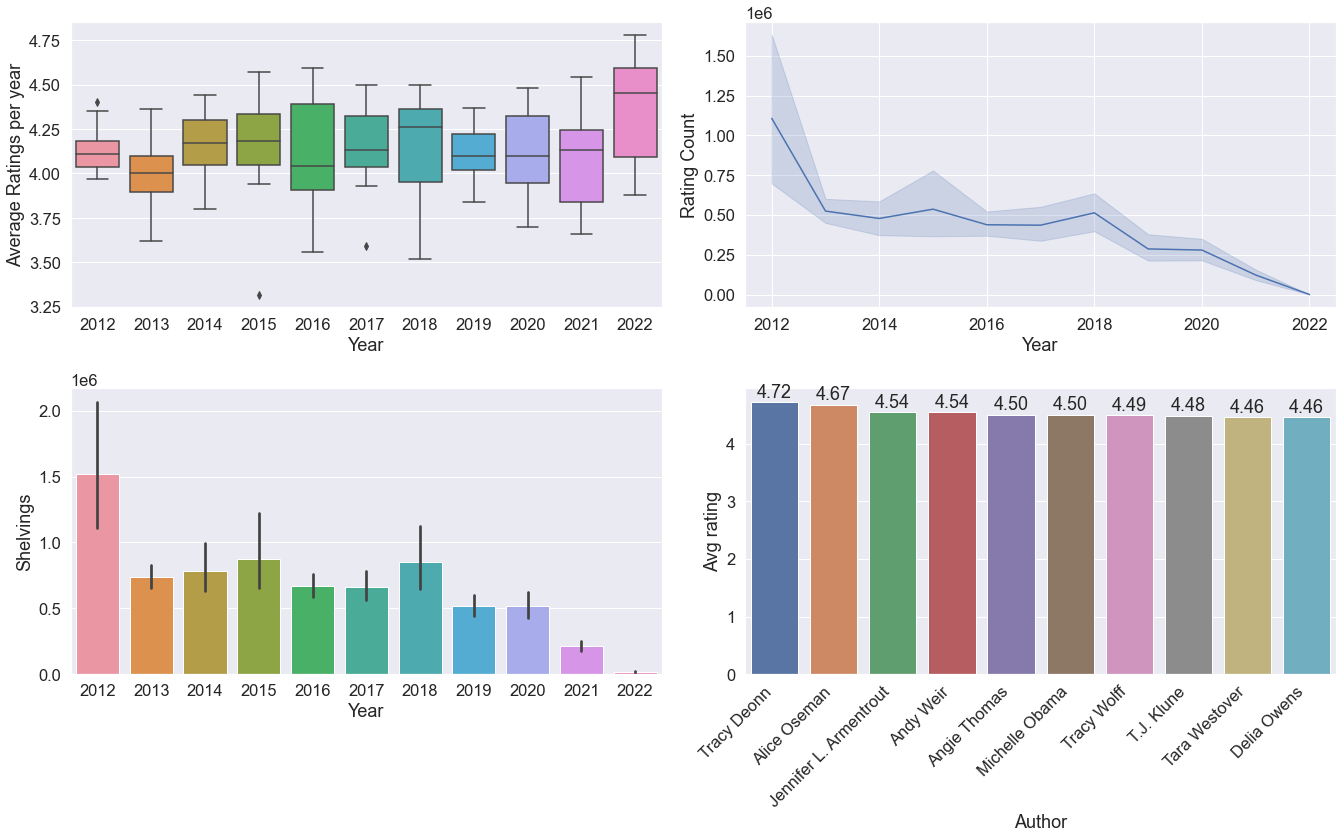

In [11]:
book_df_sorted = book_df.groupby(
    ['Author'], as_index=False).mean().sort_values('Avg rating', ascending=False)
# here as_index is very important to use otherwise the column Author will be used as index and we don't want that here.

plt.figure(figsize=(19, 12))
plt.style.use('ggplot')
sns.set(font_scale = 1.5)

ax1 = plt.subplot(2,2,1)
sns.boxplot(data=book_df_mean, x='Year', y=('Avg rating'))
plt.ylabel("Average Ratings per year")

ax2 = plt.subplot(2,2,2)
sns.lineplot(data=book_df_mean, x='Year', y=('Rating Count'))

ax3 = plt.subplot(2,2,3)
sns.barplot(data = book_df_mean, x='Year', y = "Shelvings")

ax4 = plt.subplot(2,2,4)
sns.barplot(data=book_df_sorted[:10], x='Author', y='Avg rating')
plt.setp(ax4.get_xticklabels(), rotation=45, ha = 'right')
for patch in ax4.patches:
    ax4.annotate("{:.2f}".format(patch.get_height()),  # this is the text/label
                    (patch.get_x()+patch.get_width()/2, patch.get_height()), # (x, y) these are the coordinates to position the label
                    ha = 'center', va= 'center', # horizontal and vertical alignment, can be left, right, center.
                    xytext = (0,10), # distance from text to points (x,y)
                    textcoords = 'offset points') # how to position the label

plt.tight_layout()
plt.show()


In [12]:
fig = make_subplots(rows=2, cols=2)
#1
fig.add_trace(go.Box(x=book_df_mean['Year'], y=book_df_mean['Avg rating']), row=1, col=1)
#2
fig.add_trace(go.Scatter(x=book_df_mean['Year'],
                     y=book_df_mean['Rating Count']), row=1, col=2)
#3
fig.add_trace(go.Bar(x = book_df_mean["Year"], y = book_df_mean["Shelvings"]), row=2, col=1)

#4
fig.add_trace(
    go.Bar(y=book_df_sorted['Avg rating'][:15], 
            x=book_df_sorted["Author"][:15] 
            ), row=2, col=2)

fig.update_layout(autosize= False, width=1000, height= 500, 
                    margin=dict(l=20, r=20, t=20, b=20, pad=10),
                    showlegend=False)

fig.show()